<a href="https://colab.research.google.com/github/jgalazka/ERCC_analysis/blob/main/GLDS-235-Liver/GLDS_235_Liver_ERCC_DESeq2" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeneLab ERCC spike-in analysis notebook

This notebook contains an analysis of RNA-seq counts data generated from ERCC spike-ins.

Here GLDS-235 Liver is analyzed.

This notebook focuses on DESeq2 analysis of ERCC counts


## Setting up the notebook

In [4]:
# Set-up notebook to allow inline running of R code
# Having done this, any code block starting with %RR will be run as R
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
# Install R libraries necessary
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("DESeq2")

In [ ]:
# Load R libraries
%%R
library(DESeq2)

In [1]:
# import python packages
import pandas as pd
import numpy as np
from urllib.request import urlopen, quote, urlretrieve
from json import loads
from re import search
import zipfile
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
# Function to pull metadata zip from GeneLab
# Credit to Kirill Grigorev
GENELAB_ROOT = "https://genelab-data.ndc.nasa.gov"
GLDS_URL_PREFIX = GENELAB_ROOT + "/genelab/data/study/data/"
FILELISTINGS_URL_PREFIX = GENELAB_ROOT + "/genelab/data/study/filelistings/"
ISA_ZIP_REGEX = r'.*_metadata_.*[_-]ISA\.zip$'

def read_json(url):
    with urlopen(url) as response:
        return loads(response.read().decode())

def get_isa(accession):
    glds_json = read_json(GLDS_URL_PREFIX + accession)
    try:
        _id = glds_json[0]["_id"]
    except (AssertionError, TypeError, KeyError, IndexError):
        raise ValueError("Malformed JSON?")
    isa_entries = [
        entry for entry in read_json(FILELISTINGS_URL_PREFIX + _id)
        if search(ISA_ZIP_REGEX, entry["file_name"])
    ]
    if len(isa_entries) == 0:
        raise ValueError("Unexpected: no ISAs found")
    elif len(isa_entries) > 1:
        raise ValueError("Unexpected: multiple files match the ISA regex")
    else:
        entry = isa_entries[0]
        version = entry["version"]
        url = GENELAB_ROOT + entry["remote_url"] + "?version={}".format(version)
        alt_url = (
            GENELAB_ROOT + "/genelab/static/media/dataset/" +
            quote(entry["file_name"]) + "?version={}".format(version)
        )
        return entry["file_name"], version, url, alt_url

In [3]:
# Function to pull unnormalized counts from GeneLab
# Credit to Kirill Grigorev

RAW_COUNTS_REGEX = r'.*_rna_seq_Unnormalized_Counts.csv'

def get_rawcounts(accession):
    glds_json = read_json(GLDS_URL_PREFIX + accession)
    try:
        _id = glds_json[0]["_id"]
    except (AssertionError, TypeError, KeyError, IndexError):
        raise ValueError("Malformed JSON?")
    raw_counts_entries = [
        entry for entry in read_json(FILELISTINGS_URL_PREFIX + _id)
        if search(RAW_COUNTS_REGEX, entry["file_name"])
    ]
    if len(raw_counts_entries) == 0:
        raise ValueError("Unexpected: no Raw Counts found")
    elif len(raw_counts_entries) > 1:
        raise ValueError("Unexpected: multiple files match the Raw Counts regex")
    else:
        entry = raw_counts_entries[0]
        version = entry["version"]
        url = GENELAB_ROOT + entry["remote_url"] + "?version={}".format(version)
        alt_url = (
            GENELAB_ROOT + "/genelab/static/media/dataset/" +
            quote(entry["file_name"]) + "?version={}".format(version)
        )
        return entry["file_name"], version, url, alt_url

## Get and parse data and metadata
Get ISA, counts, and ERCC data.

In [7]:
accession = 'GLDS-235' # Change this as necessary
isaurl = get_isa(accession)[3]
filehandle, _ = urlretrieve(isaurl)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist() # Print contents of zip file. Pick relevant one from list

['s_Freezing Study_Liver.txt',
 'i_Investigation.txt',
 'a_freezing_study_liver_transcription_profiling_RNA_Sequencing_(RNA-Seq).txt']

In [ ]:
sample_file = zip_file_object.namelist()[0]
file = zip_file_object.open(sample_file)
sample_table = pd.read_csv(zip_file_object.open(sample_file), sep='\t')

assay_file = zip_file_object.namelist()[2]
file = zip_file_object.open(assay_file)
assay_table = pd.read_csv(zip_file_object.open(assay_file), sep='\t')

In [ ]:
#sample_table.head(n=3)

In [ ]:
#assay_table.head(n=3)

In [ ]:
# Get raw counts table
raw_counts_file = get_rawcounts('GLDS-235')[3]
raw_counts_table = pd.read_csv(raw_counts_file, index_col=0)
raw_counts_table.index.rename('Gene_ID', inplace=True)
#raw_counts_table.head(n=3)

In [ ]:
# Get ERCC counts
ercc_counts = raw_counts_table[raw_counts_table.index.str.contains('^ERCC-')]
#ercc_counts.head(n=3)

In [ ]:
# Get ERCC files
ercc_url = 'https://assets.thermofisher.com/TFS-Assets/LSG/manuals/cms_095046.txt'
filehandle, _ = urlretrieve(ercc_url)
ercc_table = pd.read_csv(filehandle, '\t')
#ercc_table.head(n=3)

## Single Sample ERCC Analysis
Because samples may be combined by users outside of their original study, it is useful to have ERCC metrics that can be calculated from single samples. These could include: limit of detection, dynamic range, R^2 from measured vs expected plot, etc.

In [ ]:
# Make a dictionary for ERCC concentrations for each mix
mix1_conc_dict = dict(zip(ercc_table['ERCC ID'], ercc_table['concentration in Mix 1 (attomoles/ul)']))
mix2_conc_dict = dict(zip(ercc_table['ERCC ID'], ercc_table['concentration in Mix 2 (attomoles/ul)']))

In [ ]:
# get samples that use mix 1 and mix 2
mix1_samples = assay_table[assay_table['Parameter Value[Spike-in Mix Number]'] == 'Mix 1']['Sample Name']
mix2_samples = assay_table[assay_table['Parameter Value[Spike-in Mix Number]'] == 'Mix 2']['Sample Name']

In [ ]:
ercc_counts_mix_1 = ercc_counts[mix1_samples]
ercc_counts_mix_1['ERCC conc'] = ercc_counts_mix_1.index.map(mix1_conc_dict)
#ercc_counts_mix_1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
ercc_counts_mix_2 = ercc_counts[mix2_samples]
ercc_counts_mix_2['ERCC conc'] = ercc_counts_mix_2.index.map(mix2_conc_dict)
#ercc_counts_mix_2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#ercc_counts_mix_2.head(n=3)

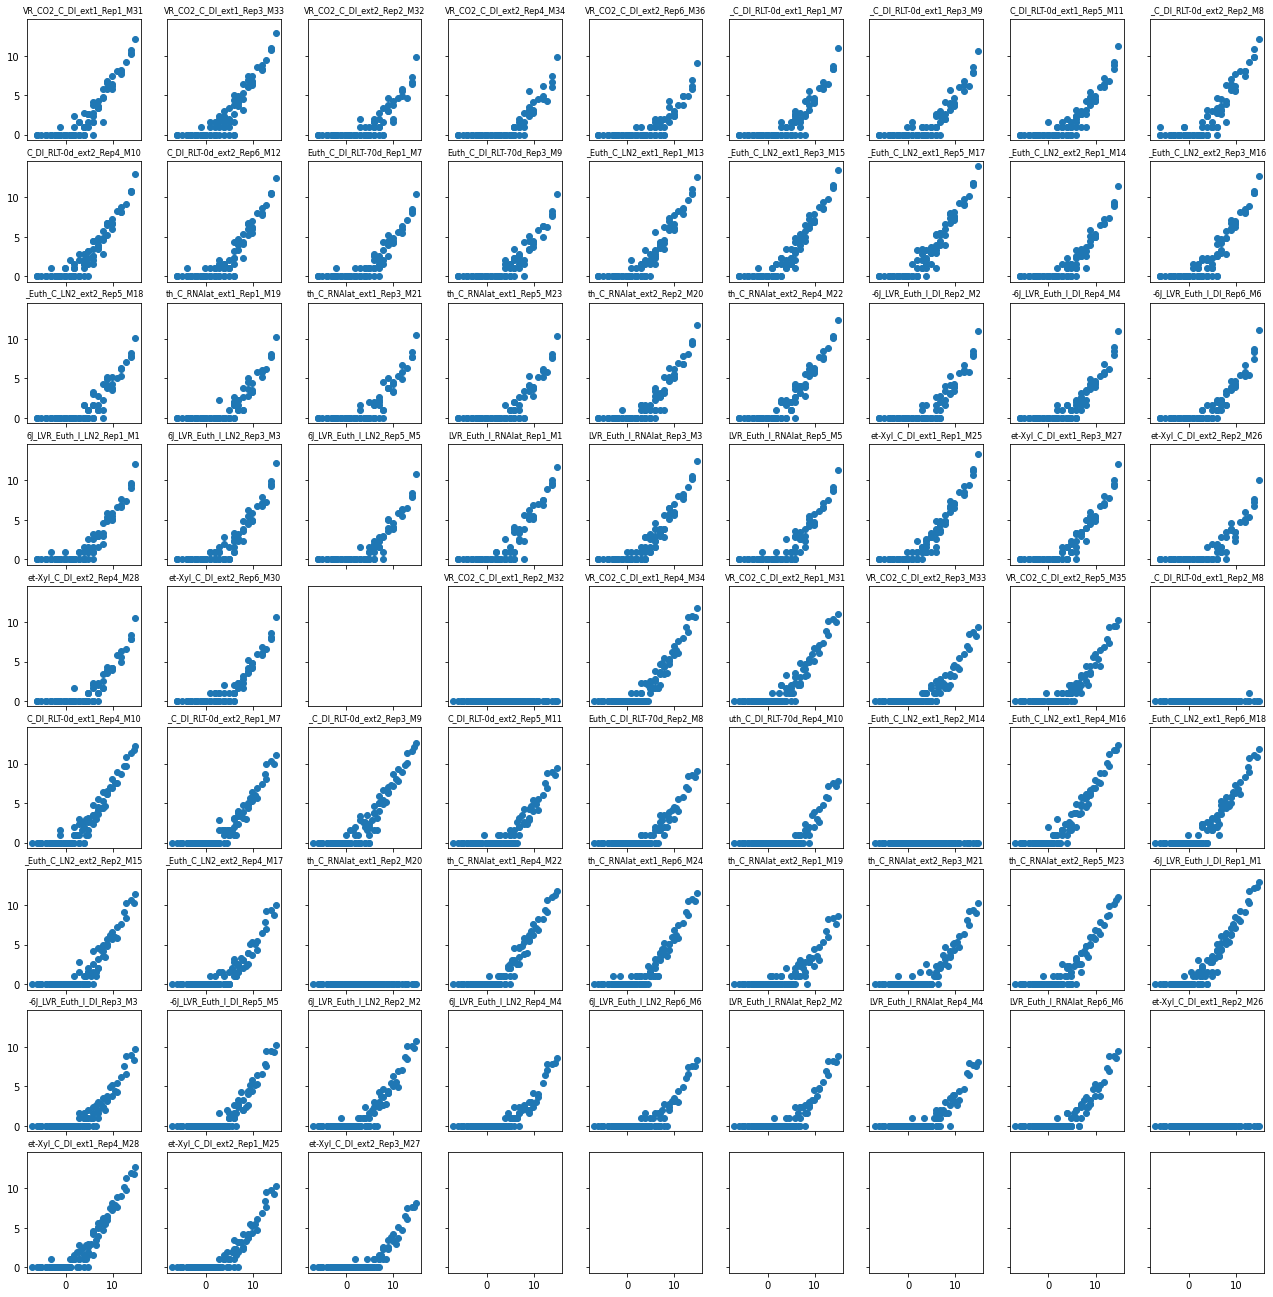

In [ ]:
columns_mix_1 = ercc_counts_mix_1.columns
columns_mix_2 = ercc_counts_mix_2.columns
all_columns = columns_mix_1.to_list() + columns_mix_2.to_list()
total_columns = len(columns_mix_1) + len(columns_mix_2) - 2
side_size = np.int(np.ceil(np.sqrt(total_columns)))# calculate grid side size. take sqrt of total plots and round up.
fig, axs = plt.subplots(side_size, side_size, figsize=(18,18), sharex='all', sharey='all')
fig.tight_layout()

counter = 0
for ax in axs.flat:
    
    if(counter < len(columns_mix_1)-1):
      ax.scatter(x=np.log2(ercc_counts_mix_1['ERCC conc']), y=np.log2(ercc_counts_mix_1[all_columns[counter]]+1))
      ax.set_title(all_columns[counter][-25:], fontsize=8)
    
    elif(counter >= len(columns_mix_1) and counter < total_columns):
      ax.scatter(x=np.log2(ercc_counts_mix_2['ERCC conc']), y=np.log2(ercc_counts_mix_2[all_columns[counter]]+1))
      ax.set_title(all_columns[counter][-25:], fontsize=8)
    
    else:
      pass

    counter = counter + 1

In [ ]:
nonzero_counts_list_1 = []
for i in range(0, len(ercc_counts_mix_1.columns)-1):
  counts = ercc_counts_mix_1[columns_mix_1[i]]
  counts.index.rename('Gene_ID', inplace=True)
  countsdf = pd.DataFrame(counts)
  nonzero_counts = countsdf[ercc_counts_mix_1[columns_mix_1[i]] > 0.0]
  nonzero_counts['Conc'] = nonzero_counts.index.map(mix1_conc_dict)
  nonzero_counts.columns = ['Counts','Conc']
  nonzero_counts_sorted = nonzero_counts.sort_values('Conc')
  nonzero_counts_list_1.append(nonzero_counts_sorted)

nonzero_counts_list_2 = []
for i in range(0, len(ercc_counts_mix_2.columns)-1):
  counts = ercc_counts_mix_2[columns_mix_2[i]]
  counts.index.rename('Gene_ID', inplace=True)
  countsdf = pd.DataFrame(counts)
  nonzero_counts = countsdf[ercc_counts_mix_2[columns_mix_2[i]] > 0.0]
  nonzero_counts['Conc'] = nonzero_counts.index.map(mix2_conc_dict)
  nonzero_counts.columns = ['Counts','Conc']
  nonzero_counts_sorted = nonzero_counts.sort_values('Conc')
  nonzero_counts_list_2.append(nonzero_counts_sorted)

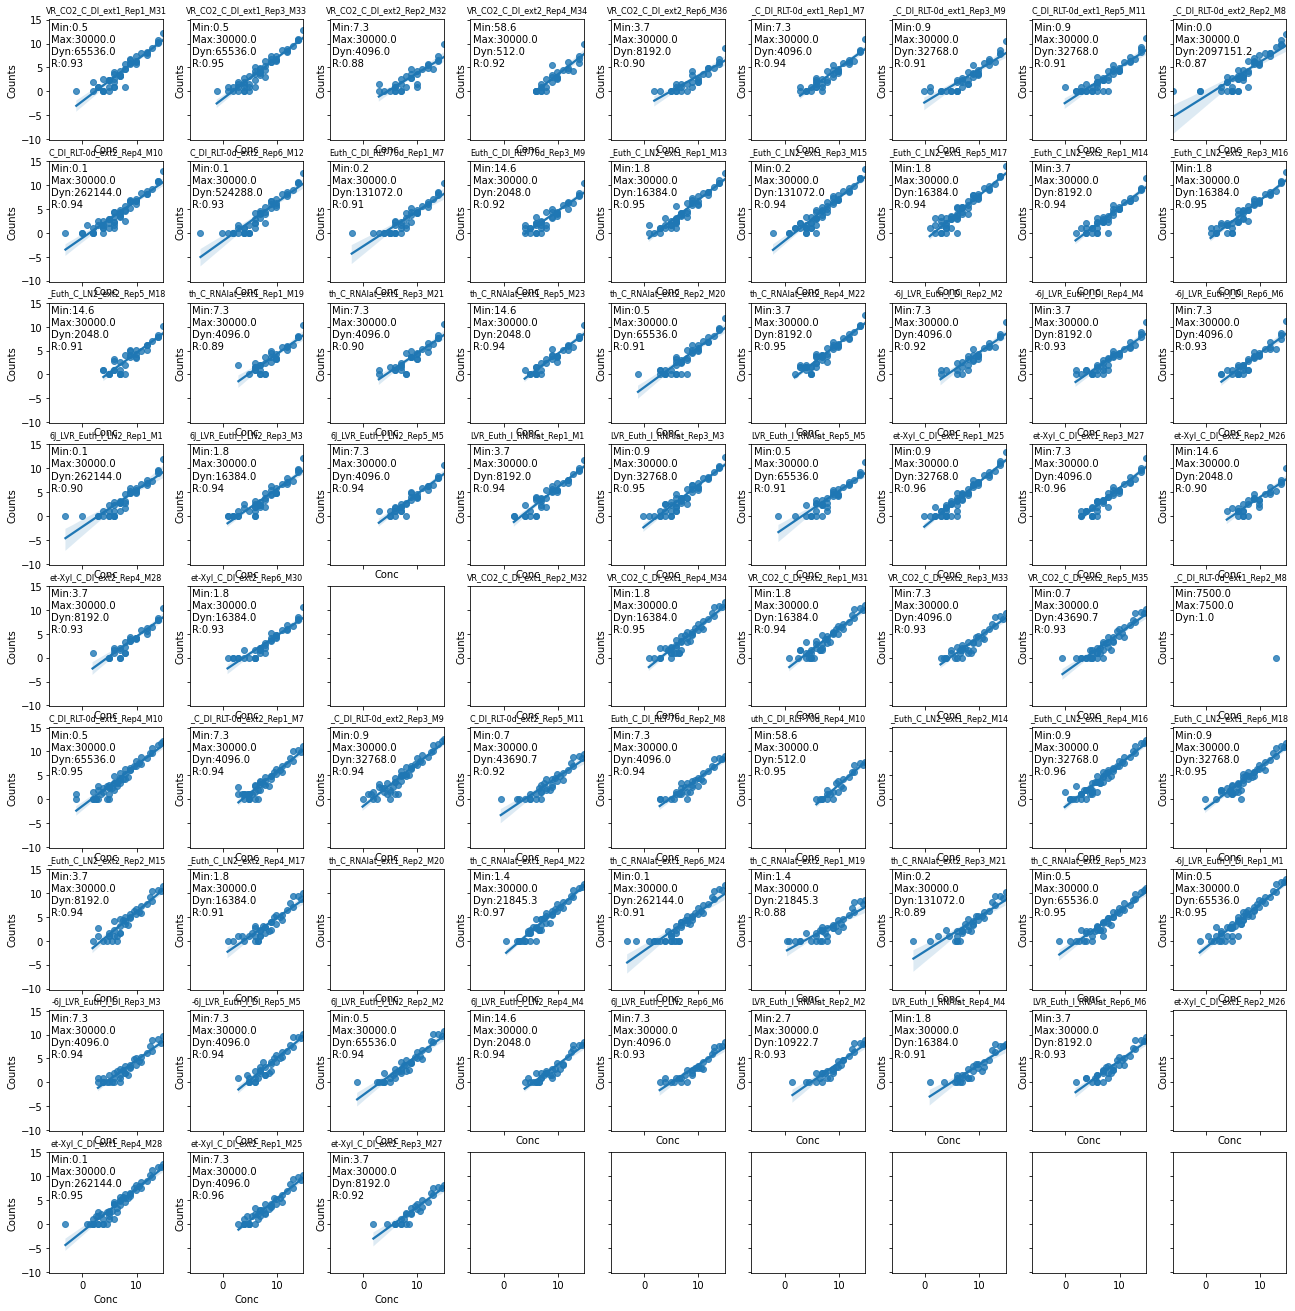

In [ ]:
samples = []
mins = []
maxs = []
dyranges = []
rs = []

fig, axs = plt.subplots(side_size, side_size, figsize=(18,18), sharex='all', sharey='all')
fig.tight_layout()

counter = 0
list2counter = 0
for ax in axs.flat:
    
    if(counter < len(columns_mix_1)-1):

      nonzero_counts = nonzero_counts_list_1[counter]
      xvalues = nonzero_counts['Conc']
      yvalues = nonzero_counts['Counts']

      sns.regplot(x=np.log2(xvalues), y=np.log2(yvalues), ax=ax)
      ax.set_title(all_columns[counter][-25:], fontsize=8)
      samples.append(all_columns[counter])

      if(len(xvalues) == 0):
        mins.append('NaN')
        maxs.append('NaN')
        dyranges.append('NaN')
        rs.append('NaN')

    
      else:
        min = xvalues[0]
        mins.append(min)
        minimum = f'Min:{min:.1f}'
        max = xvalues[-1]
        maxs.append(max)
        maximum = f'Max:{max:.1f}'
        dynamic_range = max / min
        dyranges.append(dynamic_range)
        dyn_str = f'Dyn:{dynamic_range:.1f}'

        ax.text(0.02, 0.98, minimum,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=10)
      
        ax.text(0.02, 0.88, maximum,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=10)
      
        ax.text(0.02, 0.78, dyn_str,verticalalignment='top',
                horizontalalignment='left',transform=ax.transAxes,
                color='black', fontsize=10)
      
        if(len(xvalues) == 1):
          rs.append('NaN')

        else:
          slope, intercept, r, p, se = linregress(np.log2(xvalues), y=np.log2(yvalues))
          r_str = f'R:{r:.2f}'
          rs.append(r)

          ax.text(0.02, 0.68, r_str, verticalalignment='top',
                  horizontalalignment='left',transform=ax.transAxes,
                  color='black', fontsize=10)
    
    elif(counter >= len(columns_mix_1) and counter < total_columns):
      
      nonzero_counts = nonzero_counts_list_2[list2counter]
      xvalues = nonzero_counts['Conc']
      yvalues = nonzero_counts['Counts']

      sns.regplot(x=np.log2(xvalues), y=np.log2(yvalues), ax=ax)
      ax.set_title(all_columns[counter][-25:], fontsize=8)
      samples.append(all_columns[counter])


      if(len(xvalues) == 0):
        mins.append('NaN')
        maxs.append('NaN')
        dyranges.append('NaN')
        rs.append('NaN')
    
      else:
        min = xvalues[0]
        mins.append(min)
        minimum = f'Min:{min:.1f}'
        max = xvalues[-1]
        maxs.append(max)
        maximum = f'Max:{max:.1f}'
        dynamic_range = max / min
        dyranges.append(dynamic_range)
        dyn_str = f'Dyn:{dynamic_range:.1f}'

        ax.text(0.02, 0.98, minimum,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=10)
      
        ax.text(0.02, 0.88, maximum,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=10)
      
        ax.text(0.02, 0.78, dyn_str,verticalalignment='top',
                horizontalalignment='left',transform=ax.transAxes,
                color='black', fontsize=10)
      
        if(len(xvalues) == 1):
          rs.append('NaN')
          
        else:
          slope, intercept, r, p, se = linregress(np.log2(xvalues), y=np.log2(yvalues))
          r_str = f'R:{r:.2f}'
          rs.append(r)

          ax.text(0.02, 0.68, r_str, verticalalignment='top',
                  horizontalalignment='left',transform=ax.transAxes,
                  color='black', fontsize=10)

      list2counter = list2counter + 1
    
    else:
      pass

    counter = counter + 1

In [ ]:
stats = pd.DataFrame(list(zip(samples, mins, maxs, dyranges, rs)))
stats.columns = ['Samples', 'Min', 'Max', 'Dynamic range', 'R']
stats.to_csv('ERCC_stats.csv')